# 1. Download the dataset from Kaggle's API

In [2]:
# download the data
import kagglehub

# Download the dataset (cached locally if already downloaded)
path = kagglehub.dataset_download("himanshuwagh/spotify-million")

print("📁 Dataset path:", path)

Download already complete (5585657586 bytes).
Extracting files...
📁 Dataset path: /Users/nickhellmer/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1


# 2. Exploring the data

In [5]:
import os

data_dir = os.path.expanduser("~/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1")
slice_files = sorted(os.listdir(data_dir))
print("Total files:", len(slice_files))
print("First 5 files:", slice_files[:5])

Total files: 6
First 5 files: ['README.md', 'data', 'license.txt', 'md5sums', 'src']


In [6]:
# update data directory to location of the 1,000 JSONs
data_dir = os.path.expanduser("~/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1/data")
# inspect again 
slice_files = sorted(os.listdir(data_dir))
print("Total JSON slice files:", len(slice_files))
print("First 5 slices:", slice_files[:5])

Total JSON slice files: 1000
First 5 slices: ['mpd.slice.0-999.json', 'mpd.slice.1000-1999.json', 'mpd.slice.10000-10999.json', 'mpd.slice.100000-100999.json', 'mpd.slice.101000-101999.json']


## *2.1 Inpect the first slice of the data (first 1,000 playlists)*

In [7]:
import json

# load first 1000 playlists
first_1000 = os.path.join(data_dir, "mpd.slice.0-999.json")
with open(first_1000, "r") as f:
    data_1000 = json.load(f)

# Check top-level keys
print("Top-level keys:", data_1000.keys())

# Preview first 2 playlists
playlists_1000 = data_1000["playlists"]
print(f"Number of playlists in this slice: {len(playlists)}")

for i in range(2):
    print(f"\nPlaylist {i} (pid={playlists_1000[i]['pid']}):")
    print("  Name:", playlists_1000[i]["name"])
    print("  Num tracks:", playlists_1000[i]["num_tracks"])
    print("  Track URIs:", [track["track_uri"] for track in playlists_1000[i]["tracks"]])

Top-level keys: dict_keys(['info', 'playlists'])
Number of playlists in this slice: 1000

Playlist 0 (pid=0):
  Name: Throwbacks
  Num tracks: 52
  Track URIs: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv', 'spotify:track:1AWQoqb9bSvzTjaLralEkT', 'spotify:track:1lzr43nnXAijIGYnCT8M8H', 'spotify:track:0XUfyU2QviPAs6bxSpXYG4', 'spotify:track:68vgtRHr7iZHpzGpon6Jlo', 'spotify:track:3BxWKCI06eQ5Od8TY2JBeA', 'spotify:track:7H6ev70Weq6DdpZyyTmUXk', 'spotify:track:2PpruBYCo4H7WOBJ7Q2EwM', 'spotify:track:2gam98EZKrF9XuOkU13ApN', 'spotify:track:4Y45aqo9QMa57rDsAJv40A', 'spotify:track:1HwpWwa6bnqqRhK8agG4RS', 'spotify:track:20ORwCJusz4KS2PbTPVNKo', 'spotify:track:7k6IzwMGpxnRghE7YosnXT', 'spotify:track:1Bv0Yl01xBDZD4OQP93fyl', 'spotify:track:4omisSlTk6Dsq2iQD7MA07', 'spotify:track:7xYnUQigPoIDAMPVK79NEq', 'spotify:track:6d8A5sAx9TfdeseDvfWNHd', 'spotify:track:4pmc2AxSEq6g7hPVlJCPyP', 'spotify:track:215JYyyUnrJ98NK3KEwu6d',

# 3. Building the sythetic users

One limitation I realized in our clustering approach is that it only groups playlists based on raw artist overlap — that is, playlists are treated as similar only if they share at least some of the same artists. But in reality, I personally have playlists that don’t share any artists with each other but still reflect my personal taste. For example, I might have a classic rock playlist and a separate indie playlist with zero artist overlap, yet both belong to me. This means that real users often span multiple “disjoint” musical clusters. In our synthetic user generation, however, playlists will almost always be linked through at least one common artist, which isn’t always realistic. A future improvement could involve incorporating artist similarity into our playlist vectors. Once we develop a model to quantify how similar artists are to one another (e.g., via embeddings or co-occurrence data), we could smooth or augment each playlist’s artist vector by boosting the weights of similar artists. This would allow playlists with non-overlapping but stylistically related artists to still be clustered together, better reflecting how real users listen across genres.

## *3.1 Creating the playlist vectors via raw artist counts*

In [14]:
from collections import Counter
import json
import os
from scipy.sparse import csr_matrix
import numpy as np

In [9]:
def load_artist_vectors(slice_path):
    with open(slice_path, "r") as f:
        data = json.load(f)
    
    playlists = data["playlists"]
    artist_vectors = []
    playlist_ids = []

    for p in playlists:
        artist_counts = Counter(track["artist_uri"] for track in p["tracks"])
        artist_vectors.append(artist_counts)
        playlist_ids.append(p["pid"])

    return playlist_ids, artist_vectors

In [11]:
slice_path_1000 = os.path.join(data_dir, "mpd.slice.0-999.json")
playlist_ids_1000, artist_vector_1000s = load_artist_vectors(slice_path_1000)

## *3.2 Creating the sparse matrix of playlist vectors*

In [12]:
def build_sparse_matrix(artist_vectors):
    # create list of of all unique artists
    unique_artists = {}
    for vec in artist_vectors:
        for artist in vec:
            if artist not in unique_artists:
                unique_artists[artist] = len(unique_artists)

    # create data for the sparse matrix
    rows, cols, data = [], [], []
    for row_idx, vec in enumerate(artist_vectors):
        for artist, count in vec.items():
            col_idx = unique_artists[artist]
            rows.append(row_idx)
            cols.append(col_idx)
            data.append(count)

    # create sparse matrix
    matrix = csr_matrix((data, (rows, cols)), shape=(len(artist_vectors), len(unique_artists)))
    return matrix, unique_artists

In [15]:
sparse_matrix_1000, artist_vocab_1000 = build_sparse_matrix(artist_vector_1000s)
print("Matrix shape:", sparse_matrix_1000.shape)

Matrix shape: (1000, 9754)


## *3.3 Creating the synthetic users*
- Idea 1: talk about how kmeans vs kmediods was considered. Provide reasoning as to why kmeans (the selected method) works even tho we are using cosine similarity as our distance metric instead of euclidean (bc we are normalizing the vectors first)
- Idea 2: instead of performing kmeans by finding and using the optimal k (number of clusters), can instead determine the number of clusters based on the average number of playists a standard spotify user has 
> this link https://soundplate.com/how-many-playlists-are-there-on-spotify-and-other-spotify-stats/ claims that as of 2024 there were 356 million spotify users and 8 billion user-curated playlists. This means the average user has ~23 playlists.

## *3.3.1 Use kmeans to create clusters*

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import numpy as np

In [41]:
def cluster_playlists_kmeans(X, k_range=range(2, 30), plot_elbow=True, return_best_k=False, random_state=42, 
                            fixed_k = None, playlists_per_user = 23):

    """
    Performs K-means clustering on L2-normalized sparse artist vectors.

    Parameters:
        X (matrix) : Sparse matrix of raw artist count vectors
        k_range : Range of number of clusters (synthetic users) to test
        random_state : Random seed for reproducibility
        return_best_k : Whether to return the optimal k based on the elbow method
        fixed_k (int or None): if set, overrides optimal k search and uses this k instead
        playlists_per_user: user to determine if k if fixed_k is None and you want k = len(X) // playlists per user
    Returns:
        labels (ndarray): Cluster label for each playlist
        kmeans (KMeans object): Trained KMeans model
        best_k (int): Best k value selected
    """
    # L2 normalize
    X_norm = normalize(X, norm='l2', axis=1)
    
    # OPTION 1: if a fixed k is set
    if fixed_k is not None:
        k = fixed_k
        print(f"Using manually specified k = {k}")
        final_model = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
        final_model.fit(X_norm)
        if return_best_k:
            return final_model.labels_, final_model, k
        else:
            return final_model.labels_, final_model
    
    # OPTION 2: choose k to achieve the desired number of playlists per user
    if k_range is None:
        k = max(2, len(X) // playlists_per_user)
        print(f"Using playlists_per_user={playlists_per_user}, derived k = {k}")
        final_model = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
        final_model.fit(X_norm)
        if return_best_k:
            return final_model.labels_, final_model, k
        else:
            return final_model.labels_, final_model
    
    # OPTION 3: find best k (elbow method)
    inertias = []
    print("Running K-means for k =", list(k_range))
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
        model.fit(X_norm)
        inertias.append(model.inertia_)

    if plot_elbow:
        plt.plot(k_range, inertias, marker='o')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia (sum of squared distances)')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        plt.show()

    # find k with diminishing marginal returns (minimum of secondary differences)
    diffs = np.diff(inertias)
    second_diffs = np.diff(diffs)
    best_k_idx = np.argmin(second_diffs) + 2
    best_k = k_range[best_k_idx]

    print(f"Best k selected (via elbow heuristic): {best_k}")

    # Final fit
    final_model = KMeans(n_clusters=best_k, random_state=random_state, n_init='auto')
    final_model.fit(X_norm)

    if return_best_k:
        return final_model.labels_, final_model, best_k
    else:
        return final_model.labels_, final_model

Running K-means for k = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


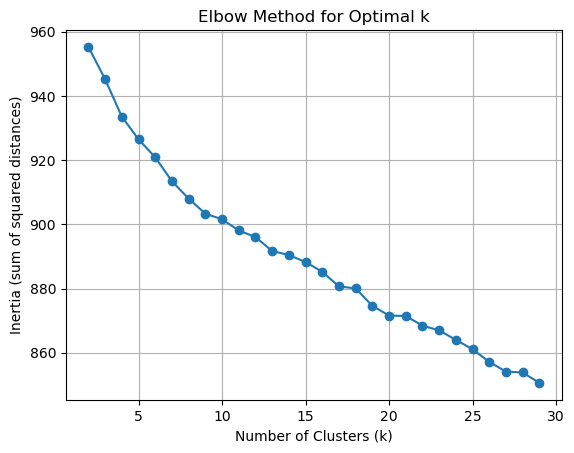

Best k selected (via elbow heuristic): 19


In [27]:
cluster_labels_1000, kmeans_model_1000, best_k_1000 = cluster_playlists_kmeans(sparse_matrix_1000, return_best_k=True)


## *3.3.2 Extract data from clusters to create users and create new synthetic dataset*

In [28]:
from collections import defaultdict

In [29]:
def extract_synthetic_users(cluster_labels, playlist_dicts): 
    """    
    Parameters:
        cluster_labels (ndarray): Cluster label for each playlist
        playlist_dicts (list): Full playlist dicts
    Returns:
        List of synthetic user JSON objects
    """

    user_playlists = defaultdict(list)

    for i, cluster_id in enumerate(cluster_labels):
        user_playlists[cluster_id].append(playlist_dicts[i])

    synthetic_users = []
    for user_id, playlists in user_playlists.items():
        synthetic_users.append({
            "username": f"user_{user_id:04x}",
            "playlists": playlists
        })

    return synthetic_users

In [31]:
playlist_dicts_1000 = data["playlists"]  # from JSON slice file
synthetic_json_1000 = extract_synthetic_users(cluster_labels_1000, playlist_dicts_1000)

# # Optional: Save to file
# import json
# with open("synthetic_users.json", "w") as f:
#     json.dump(synthetic_json, f, indent=2)

## *3.3.3 Inspecting the new synthetic json dataset*

In [32]:
import json
from collections import defaultdict
import numpy as np

In [40]:
# view output of newly created list of jsons for the first user
synthetic_json_1000[0]

{'username': 'user_0009',
 'playlists': [{'name': 'Throwbacks',
   'collaborative': 'false',
   'pid': 0,
   'modified_at': 1493424000,
   'num_tracks': 52,
   'num_albums': 47,
   'num_followers': 1,
   'tracks': [{'pos': 0,
     'artist_name': 'Missy Elliott',
     'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
     'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk',
     'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)',
     'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
     'duration_ms': 226863,
     'album_name': 'The Cookbook'},
    {'pos': 1,
     'artist_name': 'Britney Spears',
     'track_uri': 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak',
     'artist_uri': 'spotify:artist:26dSoYclwsYLMAKD3tpOr4',
     'track_name': 'Toxic',
     'album_uri': 'spotify:album:0z7pVBGOD7HCIB7S8eLkLI',
     'duration_ms': 198800,
     'album_name': 'In The Zone'},
    {'pos': 2,
     'artist_name': 'Beyoncé',
     'track_uri': 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv',
     'ar

In [35]:
# Initialize lists to store per-user stats
playlist_counts = []
unique_track_counts = []
unique_artist_counts = []

for user in synthetic_json_1000:
    playlist_counts.append(len(user["playlists"]))

    user_tracks = set()
    user_artists = set()

    for pl in user["playlists"]:
        for track in pl.get("tracks", []):
            user_tracks.add(track["track_uri"])
            user_artists.add(track["artist_uri"])

    unique_track_counts.append(len(user_tracks))
    unique_artist_counts.append(len(user_artists))

In [37]:
# Summary statistics
def summarize(name, data):
    print(f"\n{name}:")
    print(f"  Avg: {np.mean(data):.2f}")
    print(f"  Min: {np.min(data)}")
    print(f"  Max: {np.max(data)}")

print(f"Total synthetic users: {len(synthetic_json_1000)}")
summarize("Playlists per user", playlist_counts)
summarize("Unique tracks per user", unique_track_counts)
summarize("Unique artists per user", unique_artist_counts)

Total synthetic users: 19

Playlists per user:
  Avg: 52.63
  Min: 12
  Max: 352

Unique tracks per user:
  Avg: 2583.11
  Min: 439
  Max: 15827

Unique artists per user:
  Avg: 1014.32
  Min: 194
  Max: 5727
